In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import json
import hashlib
from itertools import combinations

In [2]:
# plotting function from before, but with the label names
def plot_nodes_and_edges(nodes,edges,labels,pos=None):
    plt.figure(figsize=(16, 6))
    G = nx.Graph()
    for node, domain in nodes.items():
        G.add_node(node, domain=domain)
    G.add_edges_from(edges)
    if(pos is None):
        pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='white',edgecolors='red', linewidths=2,alpha=0.5)
    nx.draw_networkx_edges(G, pos,alpha=0.5)
    label_pos = {node: (x - 0.05, y + 0.035) for (node, (x, y)) in pos.items()}
    labels_with_name = {}
    for name in labels.keys():
        labels_with_name[name] = name + "\n" + str(labels[name])
    nx.draw_networkx_labels(
        G, 
        label_pos, 
        labels_with_name, 
        font_size=14,
        verticalalignment='top',
        horizontalalignment='left'
    )
    x_values, y_values = zip(*pos.values())
    plt.xlim(min(x_values) - 1, max(x_values) + 2)
    plt.ylim(min(y_values) - 1, max(y_values) + 1)
    plt.show()
    return pos # return the position so that we can reuse it for the next plot.

### 1.3.1 The asynchronous backtracking algorithm
The asynchonous backtracking algorithm can be thought of as a greedy version of the hyper-resolution algorithm. Essentially, we want every node to be trying to find a value, and then backtracking by sending a 'nogood' when it can't. This uses an arbitrary ordering of the nodes. Each node stores an idea of what the state of other nodes is, called a agent_view. Agents sent an 'OK' message to inform other nodes of their value. The algorithm is defined by 3 main functions:

**On receive a nogood**
1. Add the new nogood to your list.
2. For each item in the nogood:
    1. Add that node to your neighbours, if you haven't already.
    2. Set the agent_view of that node to it's nogood value
3. *check agent view*


**On receive OK**
1. Update agent_view to note that the message sender has a new value
2. *check agent view*


**check agent view**
1. Try to come up with a new value that is consistent with your own nogood list, and the values of neighbours.
2. If you can't, then *backtrack*
3. If you can, then send an OK message to nodes with a lower rank. 


**backtrack**
1. Generate a new nogood
2. If you can't, then terminate here. 
3. If you can, then send this new nogood to the node referenced in the nogood with the lowest rank.
4. Also then remove that nodes value from agent_view, as it will change. 
5. *check agent view*

In [3]:
def generate_new_nogood(variable_name,variable_domain,nogood_selection):
    """
        Generates a new nogood, using every rule in nogood_selection using hyper-resolution.
        Each nogood must have a value for variable_name.
        All values in domain need to be mentioned at least once. 
        The final nogood cannot assign a variable two values.
    """
    domain_coverage = dict(zip(variable_domain,[False for _ in range(len(variable_domain))]))
    new_nogood = {}
    for nogood in nogood_selection:
        if not variable_name in nogood:
            return None # this variable not in input nogood - cant substitute
        else:
            domain_value_being_replaced = nogood[variable_name]
            domain_coverage[domain_value_being_replaced] = True
            for other_variable,other_value in nogood.items():
                if not other_variable==variable_name:
                    if other_variable in new_nogood: # we have added already!
                        if not other_value==new_nogood[other_variable]:
                            return None # a variable cannot have 2 different values!
                    else:
                        new_nogood[other_variable]=other_value
    if all(domain_coverage.values()):
        return new_nogood
    else:
        return None

In [4]:
def dictionary_hash(d):
    # given a dictionary, give a hash that is the same regardless of the dictionary order.
    sorted_items = tuple(sorted(d.items()))
    json_str = json.dumps(sorted_items)
    hash_object = hashlib.sha256(json_str.encode())
    return hash_object.hexdigest()    

In [5]:
class ABT_node:
    
    def __init__ (self,name,domain,rank):
        self.name = name
        self.domain = domain
        self.all_nodes = {} # dictionary mapping names to objects.
        self.neighbour_names = [] # list of neighbour names
        self.nogoods = {} # from the unique hash of the nogood to the nogood itself
        self.agent_view = {} # beliefs about other nodes
        self.new_messages = {} # map from neighbour name to messages
        self.rank = rank
        self.need_to_check_view = True
        self.value = None
        
    def add_neighbour(self,name):
        if not name in self.neighbour_names:
            self.neighbour_names.append(name)
            if not name in self.new_messages:
                self.new_messages[name]=[]
    
    def received_OK(self,other_node_name,other_node_value):
        """
            You are a lower-rank node and have been asked if this higher node has a viable setting.
            Add the setting to agent view, and note to yourself to rerun the "check view" method. 
        """
        self.agent_view[other_node_name] = other_node_value
        self.need_to_check_view = True
    
    def received_nogood(self,nogood):
        """
            You have been told about a new nogood.
            Figure out the hash, and add it to your dictionary. 
            Then set your agent_view to the nogood values where possible.
            If a node is in this nogood but you don't have it as a neighbour, add it, and tell it to do the same.
        """
        nogood_hash = dictionary_hash(nogood)
        if not nogood_hash in self.nogoods:
            self.nogoods[nogood_hash] = nogood

        for node_name, node_value in nogood.items():
            if not node_name==self.name:
                if not node_name in self.neighbour_names:
                    add_neighbour(node_name)
                    self.agent_view[node_name]=node_value
                    self.all_nodes[node_name].new_messages[self.name]=["add neighbour",self.name]

        self.need_to_check_view = True                
    
    def check_inbox(self):
        """
            Check your inbox for new messages. You might need to add a neighbour, receive a nogood, or OK.
        """
        empty = True
        for other_name in self.new_messages.keys():
            inbox = self.new_messages[other_name]
            if len(inbox)>0:
                empty = False
                if(np.random.rand()<0.1): # random chance the message has come in
                    (message_name,message_content) = inbox.pop(0)
                    print("node",self.name,"received the message",message_name,message_content,"from",other_name)
                    if message_name=="OK":
                        self.received_OK(other_name,message_content)
                    elif message_name=="nogood":
                        self.received_nogood(message_content)
                    elif message_name=="add neighbour":
                        self.add_neighbour(message_content)
        return empty
    
    def find_new_nogood(self):
        """
            Generate a new nogood. Try taking combinations of the existing nogoods.
            Add to your list of nogoods if you find it. 
        """
        for r in range(1, len(self.nogoods) + 1):
            combinations_depth_r = list(combinations(list(range(len(self.nogoods))), r))
            for comb in combinations_depth_r:
                nogood_comb_keys = [list(self.nogoods.values())[i] for i in comb]
                new_nogood = generate_new_nogood(self.name,self.domain,nogood_comb_keys)
                if not new_nogood is None:
                    hashed_val = dictionary_hash(new_nogood)
                    if not hashed_val in self.nogoods:
                        self.nogoods[hashed_val] = new_nogood
                        return new_nogood
        return None
    
    def backtrack(self):
        """
            You are inconsistent with other nodes.
            Find a new nogood and send it to another node (the one with lowest rank in the nogood).
            If you can't generate a new nogood, then there is no solution.
        """
        new_nogood = self.find_new_nogood()
        if new_nogood is None:
            backtrack_success = False
        else:
            backtrack_success = True
            print("node",self.name,"found a new nogood:",new_nogood)
            lowest_rank = np.inf
            lowest_ranked_node = None
            for node_name in self.neighbour_names:
                if node_name in new_nogood:
                    node = self.all_nodes[node_name]
                    if node.rank < lowest_rank:
                        lowest_rank = node.rank
                        lowest_ranked_node = node
            
            if lowest_ranked_node is None:
                print("backtracking failed, terminating")
                backtrack_success = False
            else:                
                lowest_ranked_node.new_messages[self.name].append(("nogood",new_nogood))
                if lowest_ranked_node.name in self.agent_view:
                    print("node",self.name,"removed",lowest_ranked_node.name,"from agent view")
                    self.agent_view.pop(lowest_ranked_node.name)
                    self.need_to_check_view = True
        return backtrack_success
    
    def find_consistent_value(self):
        """
            Try to search your domain for a value consistent with the others. 
            A value doesn't work if there is a nogood which overlaps with the proposal.
        """
        for option in self.domain:
            proposed_settings = self.agent_view.copy()
            proposed_settings[self.name]=option
            option_works = True
            for nogood in self.nogoods.values():
                nogood_overlaps = True
                for var_name,var_value in nogood.items():
                    if not var_name in proposed_settings:
                        nogood_overlaps = False
                        break
                    else:
                        if proposed_settings[var_name]!=var_value:
                            nogood_overlaps = False
                            break
                if nogood_overlaps:
                    option_works = False
                    break
            if option_works:
                return option
        return None
    
    def check_view(self):
        """
            Try to find a new value, consistent with your view. 
            If you can't, then backtrack. 
            If you can send OK to nodes of lower rank. 
        """
        if self.need_to_check_view:
            self.need_to_check_view = False
            # try to find a new value, consistent with all nogoods
            new_value = self.find_consistent_value()
            if new_value is None:
                print("node",self.name,"could not find a value, backtracking")
                backtrack_success = self.backtrack()
                if not backtrack_success:
                    return False
            else:
                print("node",self.name,"found a consistent value:",new_value)
                self.value = new_value
                for node_name in self.neighbour_names:
                    node = self.all_nodes[node_name]
                    if node.rank < self.rank:
                        node.new_messages[self.name].append(("OK",new_value))
        return True

In [6]:
def run_ABT_algorithm(node_dict,edge_dict):    
    nodes = {} # name to object
    for rank, name in enumerate(node_dict.keys()):
        domain = node_dict[name]
        nodes[name] = ABT_node(name,domain,rank)
    
    for node in nodes.values():
        node.all_nodes = dict(zip(nodes.keys(),nodes.values()))
    
    for (node1_name,node2_name) in edge_dict:
        nodes[node1_name].add_neighbour(node2_name)
        nodes[node2_name].add_neighbour(node1_name)
        common_domain = list(set(nodes[node1_name].domain) & set(nodes[node2_name].domain))
        for value in common_domain:
            nogood = {nodes[node1_name].name:value,nodes[node2_name].name:value}
            nogood_hash = dictionary_hash(nogood)
            nodes[node1_name].nogoods[nogood_hash] = nogood
            nodes[node2_name].nogoods[nogood_hash] = nogood
    
    graph_labels = {}
    for node in nodes.values():
        domain = str(node.domain)
        view = str(node.agent_view.copy())
        value = str(node.value)
        label = "domain: "+domain+"\nview: "+view+ "\nvalue: "+value
        graph_labels[node.name] = label
    
    node_positions = plot_nodes_and_edges(node_dict,edge_dict,labels=graph_labels)
    
    for epoch in range(500):
        all_messages_read = True
        failure = False
        for node in nodes.values():
            inbox_empty = node.check_inbox()
            success = node.check_view()
            if not inbox_empty:
                all_messages_read = False
            if not success:
                failure = True
        
        new_labels = {}
        for node in nodes.values():
            domain = str(node.domain)
            view = str(node.agent_view.copy())
            value = str(node.value)
            label = "domain: "+domain+"\nview: "+view+ "\nvalue: "+value
            new_labels[node.name] = label
        
        if dictionary_hash(graph_labels)!=dictionary_hash(new_labels):
            graph_labels = new_labels
            _ = plot_nodes_and_edges(node_dict,edge_dict,labels=graph_labels,pos=node_positions)
        
        if all_messages_read and not epoch==0:
            print("no new messages, finishing")
            break
        
        if failure:
            print("no solution found, finishing")
            break

Simple example. In this case there are 3 nodes in a line. The middle one just needs a different value from the outside ones. 

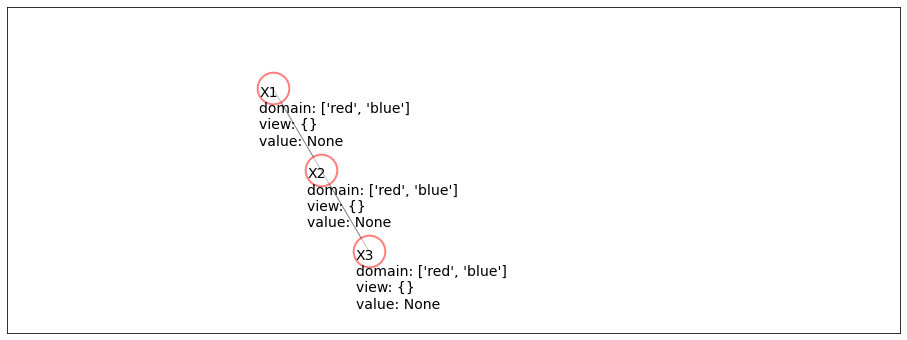

node X1 found a consistent value: red
node X2 found a consistent value: red
node X3 found a consistent value: red


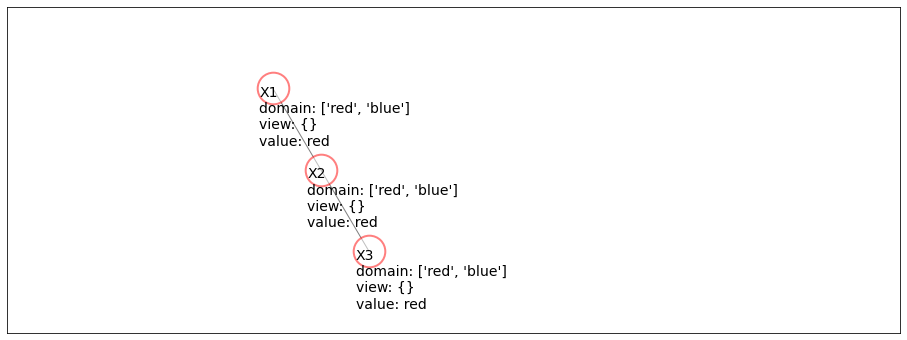

node X1 received the message OK red from X2
node X1 found a consistent value: blue


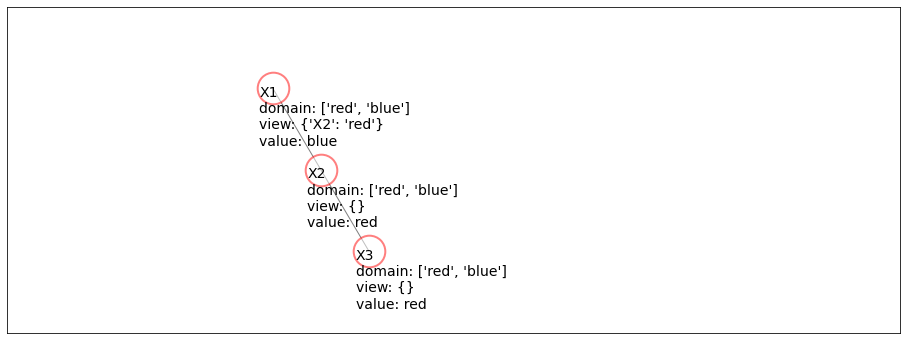

node X2 received the message OK red from X3
node X2 found a consistent value: blue


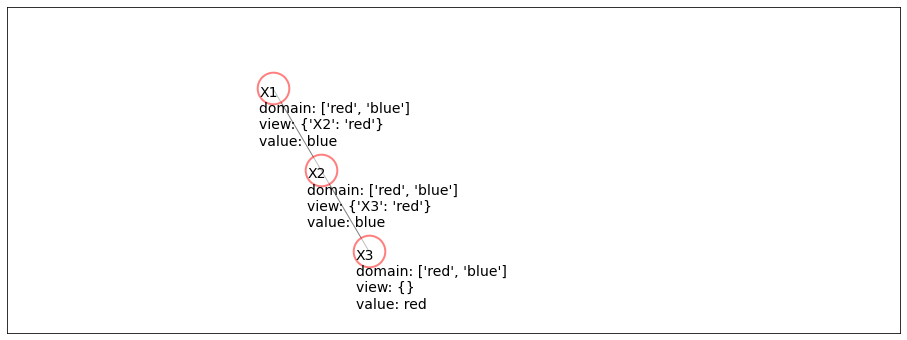

node X1 received the message OK blue from X2
node X1 found a consistent value: red


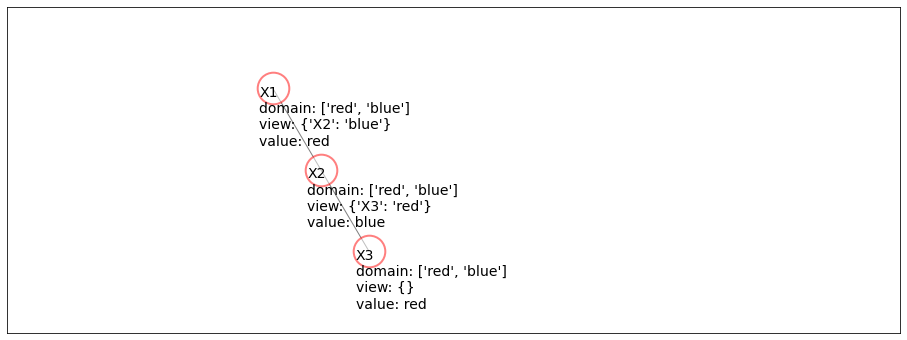

no new messages, finishing


In [7]:
run_ABT_algorithm(
    {
        "X1":["red","blue"],
        "X2":["red","blue"],
        "X3":["red","blue"]
    },
    [("X1","X2"),("X2","X3")]
)

This next example is more complicated, so takes a while longer to run. All nodes are connected.

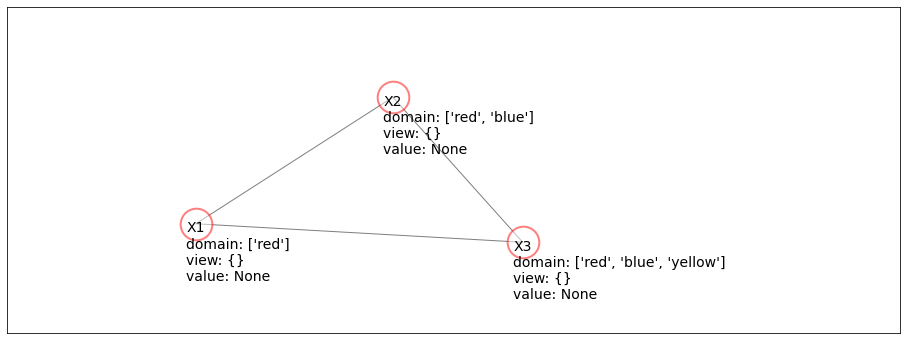

node X1 found a consistent value: red
node X2 found a consistent value: red
node X3 found a consistent value: red


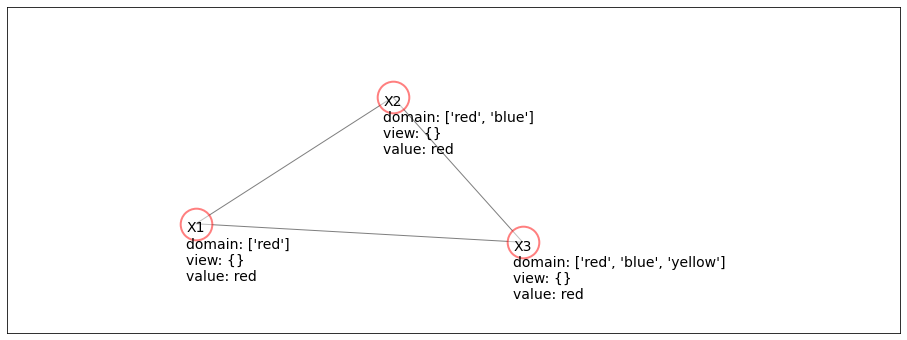

node X1 received the message OK red from X3
node X1 could not find a value, backtracking
node X1 found a new nogood: {'X2': 'red'}


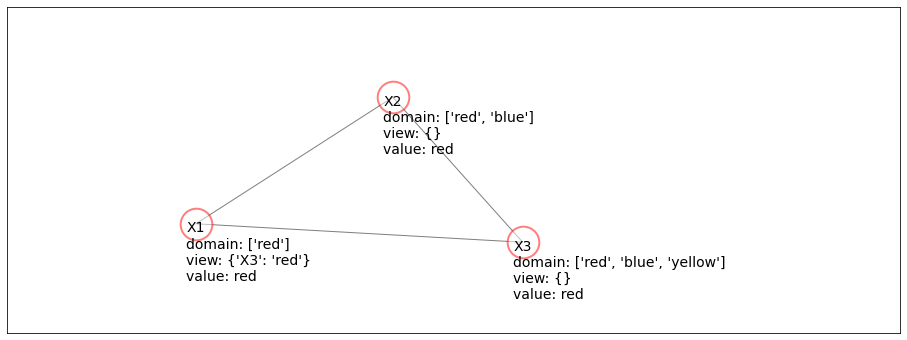

node X2 received the message OK red from X3
node X2 found a consistent value: blue


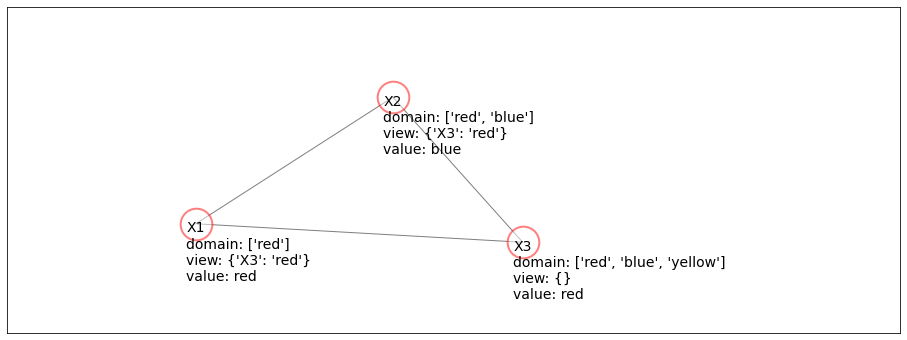

node X2 received the message nogood {'X2': 'red'} from X1
node X2 found a consistent value: blue
node X1 received the message OK red from X2
node X1 could not find a value, backtracking
node X1 found a new nogood: {'X3': 'red'}
node X1 removed X3 from agent view


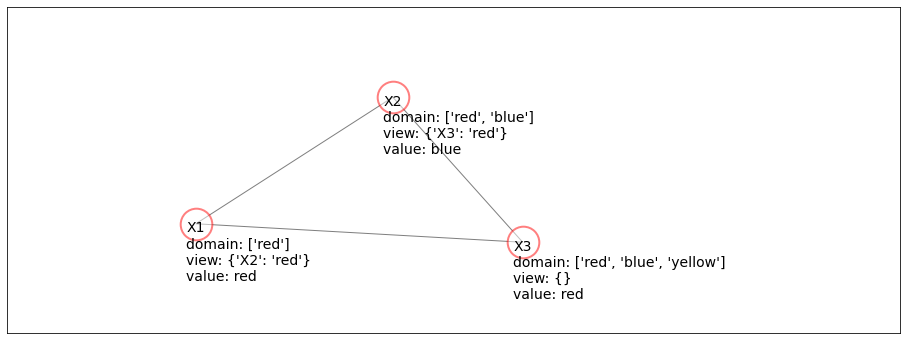

node X1 could not find a value, backtracking
node X1 found a new nogood: {'X2': 'red', 'X3': 'red'}
node X1 removed X2 from agent view
node X3 received the message nogood {'X3': 'red'} from X1
node X3 found a consistent value: blue


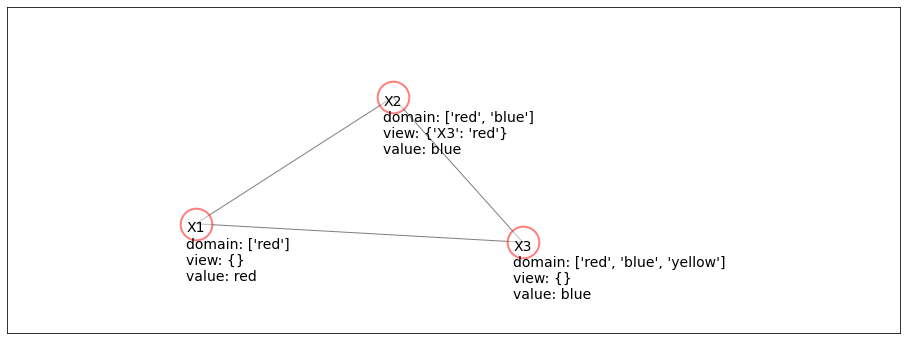

node X1 found a consistent value: red
node X2 received the message nogood {'X2': 'red', 'X3': 'red'} from X1
node X2 found a consistent value: blue
node X1 received the message OK blue from X3
node X1 found a consistent value: red


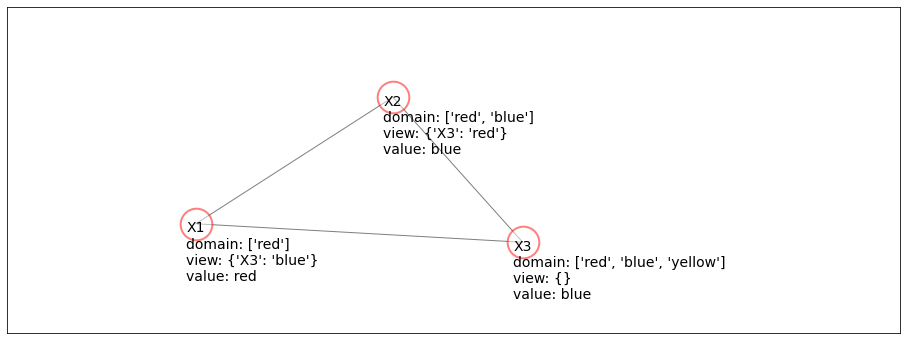

node X1 received the message OK blue from X2
node X1 found a consistent value: red


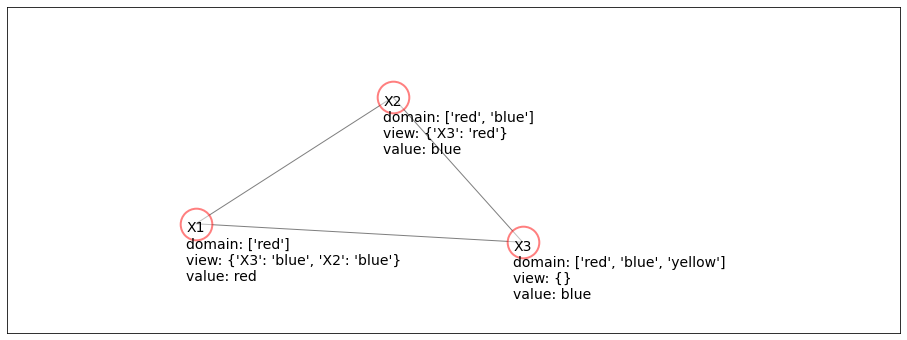

node X1 received the message OK blue from X2
node X1 found a consistent value: red
node X2 received the message OK blue from X3
node X2 could not find a value, backtracking
node X2 found a new nogood: {'X1': 'red', 'X3': 'blue'}


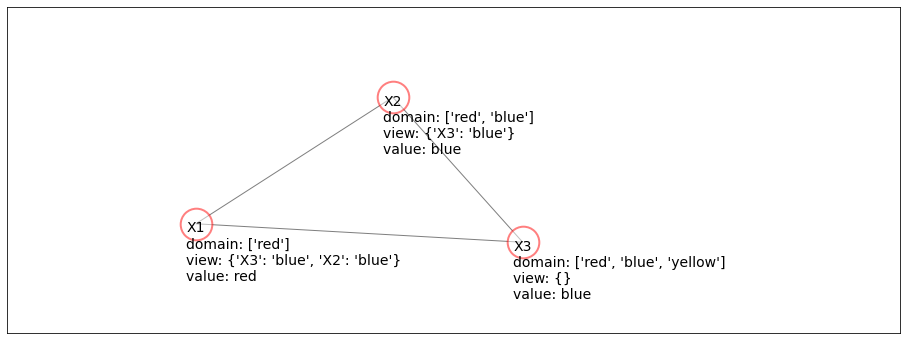

node X1 received the message OK blue from X2
node X1 found a consistent value: red
node X1 received the message nogood {'X1': 'red', 'X3': 'blue'} from X2
node X1 could not find a value, backtracking
node X1 found a new nogood: {'X3': 'blue'}
node X1 removed X3 from agent view


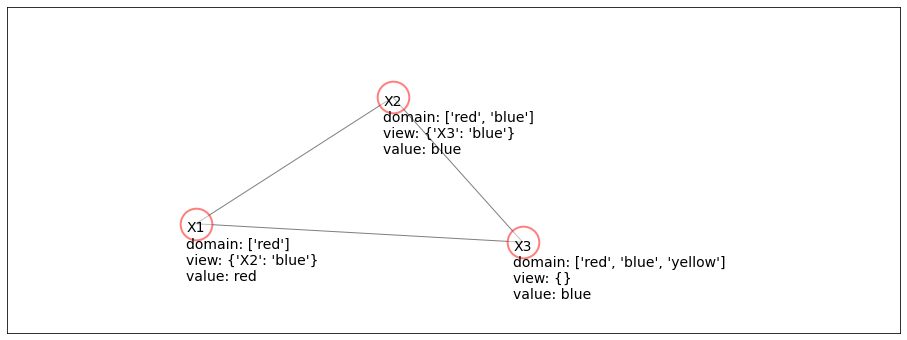

node X1 found a consistent value: red
node X3 received the message nogood {'X3': 'blue'} from X1
node X3 found a consistent value: yellow


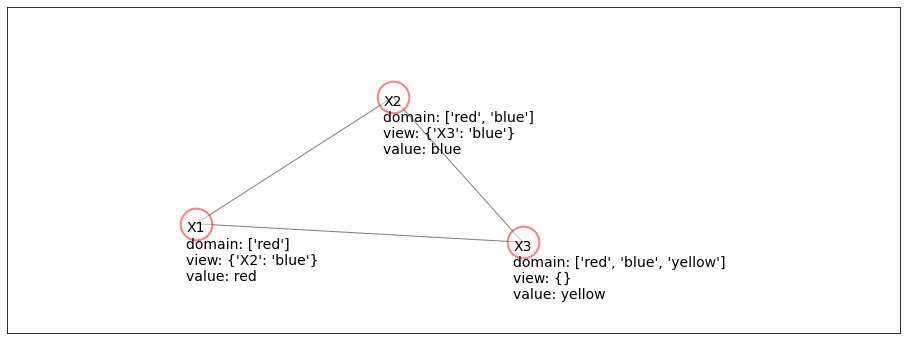

node X1 received the message OK yellow from X3
node X1 found a consistent value: red


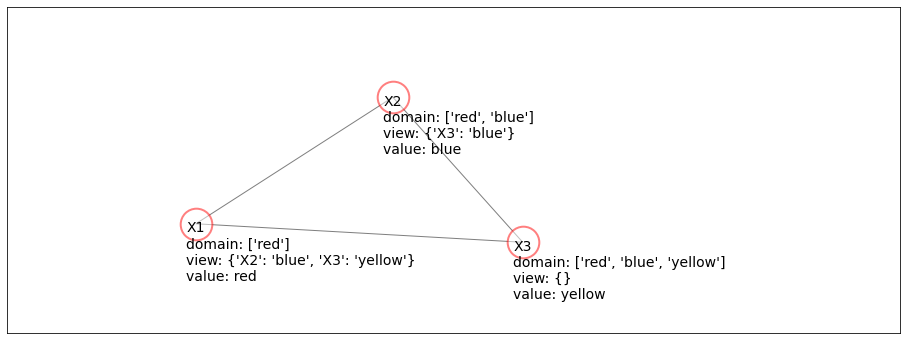

node X2 received the message OK yellow from X3
node X2 found a consistent value: blue


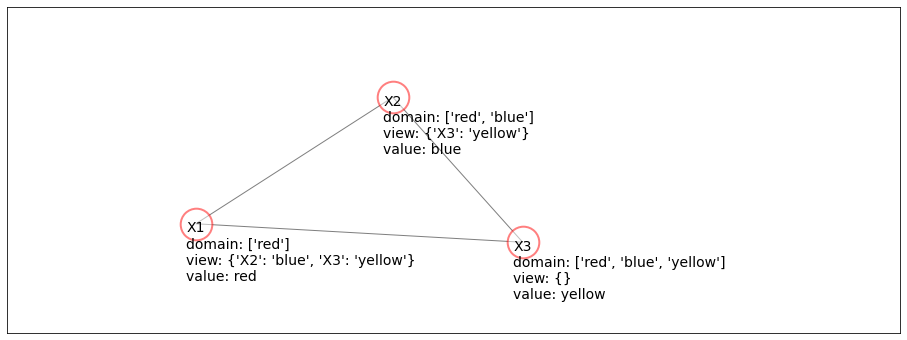

node X1 received the message OK blue from X2
node X1 found a consistent value: red
no new messages, finishing


In [8]:
run_ABT_algorithm(
    {
        "X1":["red",],
        "X2":["red","blue"],
        "X3":["red","blue","yellow"]
    },
    [("X1","X2"),("X2","X3"),("X1","X3")]
)

And if we can't identify a solution, this is found as well:

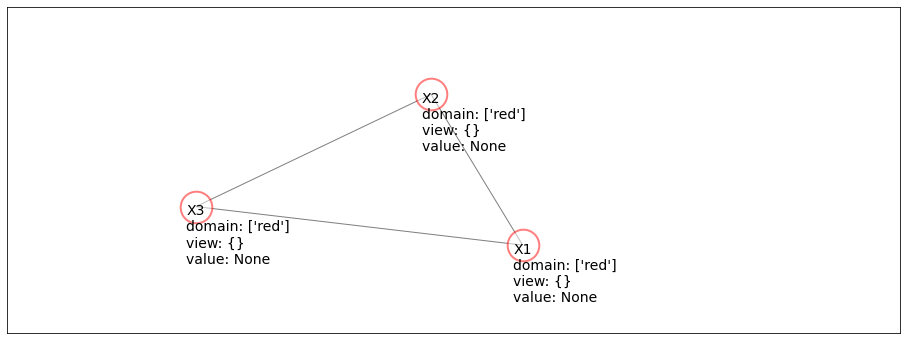

node X1 found a consistent value: red
node X2 found a consistent value: red
node X3 found a consistent value: red


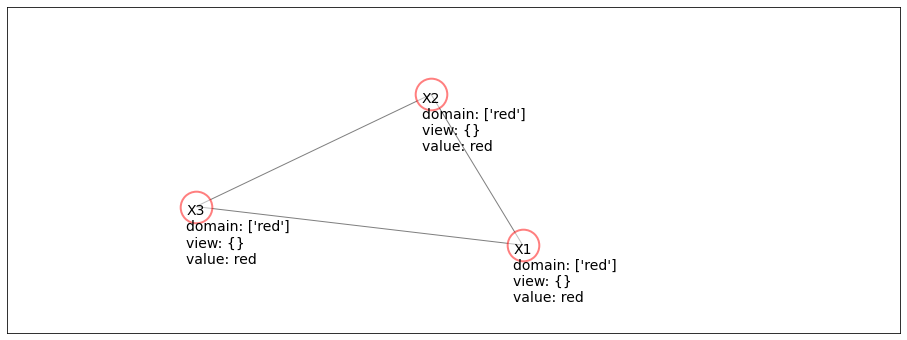

node X1 received the message OK red from X2
node X1 could not find a value, backtracking
node X1 found a new nogood: {'X2': 'red'}
node X1 removed X2 from agent view
node X1 found a consistent value: red
node X2 received the message nogood {'X2': 'red'} from X1
node X2 could not find a value, backtracking
node X2 found a new nogood: {'X1': 'red'}
node X2 received the message OK red from X3
node X2 could not find a value, backtracking
node X2 found a new nogood: {'X3': 'red'}
node X2 removed X3 from agent view
node X2 could not find a value, backtracking
node X2 found a new nogood: {}
backtracking failed, terminating
no solution found, finishing


In [9]:
run_ABT_algorithm(
    {
        "X1":["red"],
        "X2":["red"],
        "X3":["red"]
    },
    [("X1","X2"),("X2","X3"),("X1","X3")]
)

### 1.3.4 Beyond the asynchronous backtracking algorithm  
This algorithm can be improved upon in a few different ways. We can try and find nogoods which involve fewer variables. And we can try to cut down on the number of nogoods stored by agents.

Besides this algorithm there are a few other distributed constraint satisfaction solvers, such as asynchronous forward checking and concurrent dynamic backchecking. 